# 1. Background and Problem Statement

The idea of this project was to predict an amount of money that a lobbying firm pays to get a piece of legislation passed by industry. Special interest groups are allowed to contribute to candidates in congress through lobbyists to advance the interests of the organizations they represent. These lobbyists can be from any industry: Oil and Gas, Pharmaceuticals, Dairy, etc. My hypothesis was that certain industries would require much more funding over a much broader selection of committees than others. For instance, the tobacco industry may have to lobby much harder than the telecommunications industry. I would like to arrive at a dollar figure that gives X% likelihood that the bill will pass. In the end it became clear that arriving at a precise figure per industry would both take more time and more estimation than the scope of this project could handle. 

# 2. Methodology

My data sources haven't changed much. I got most of my biographical information on congresspeople from the Biographical Directory of the United States, I got most of my funding information from the OpenSecrets API, and I got most of my bill related tracking information from GovTrack. 

My initial methodology was to essentially get all of the relevant IDs in a single dataframe, and make calls out to the various web services for the information I need. I would then combine in one place, and run analytics against it. 

My final methodology ended up looking more like this: 

![Final Methodology](pictures/Final_Methodology.jpg)

I built a function that took one of a congressperson’s IDs, a congress year, and a parameter that decided whether or not to return graphs. That would then build up a list of contributions from top industries from one service and a count of relevant bills that a congressperson sponsored from another. There are some caveats to this method that future users should be aware of:
1. First, congressional sessions have to be pulled separately. This is because the function is already pulling as many bills as are relevant to the top industry donators for a congressperson. With industry categories as wide as “Health Professionals” or “Oil”, this can be thousands per industry, and most congresspeople return about 10 industries.  
2. The function has to normalize what gets fed into the API to pull bill data. Categories can include entries like “Fisheries & Wildlife” that breaks URL encoding or can refer to an industry multiple different ways. A list of API friendly search terms was built up in the file data/all_industries_search_friendly.csv. 
3. “All relevant bills” actually means “all relevant bills up to the 2000”. There’s a limit of 5999 entries that can be pulled via a single query in the GovTrack API. I then narrowed the pull to a potential of 2000 since the function is making successive calls to the API in loops. 
4. This function only measures congressional sponsorships, not cosponsorships. The idea behind this was to only measure direct action taken by congress. It should be noted by everyone that sponsorships alone don't measure the full impact a congressperson can have. They can cosponsor bills as well as oppose them. 
5. Finally, this methodology measures the positive actions that a congressperson can take. It has no way of knowing if industry lobbying dollars were given to a candidate to chage wording on a document or to oppose it. 

# 3. Data and Feature Analysis

The data for this project came from a few bulk files and 2 APIs: the Open Secrets API (https://www.opensecrets.org/resources/create/apis.php) and the GovTrack API (https://www.govtrack.us/developers/api). Any information relating to the sponors on bills came from GovTrack, and any information on lobbying dollars came from Open Secrets. 

In [17]:
import requests 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split

The first thing that I did is get a bunch of the relevant ID information into a single place. Below is code to read in IDs for all of congress, read in committee codes for all committees (for the committee based functions), and pull in industry codes and API safe queries for those industries to be used later. 

In [18]:
all_congress_ids = pd.read_csv('data/legislators-current.csv')

all_committee_codes = pd.read_csv('data/all_committees.txt', sep='\t')

industry_pull = pd.read_csv('data/all_industries.txt', sep='\t')
all_industry_codes = industry_pull[['Catorder', 'Industry']].drop_duplicates()
all_industry_codes = all_industry_codes.set_index('Catorder')

#Reads in the industry file and creates a dictionary of API search terms that are friendly to URL encoding
def read_industry_file():
    with open('data/all_industries_search_friendly.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter= ',')
        return_dict = {}
        for row in readCSV:
            return_dict[row[1]] = row[2]
        return return_dict
    
all_industries = read_industry_file() 

In [19]:
all_congress_ids #Only the OSIDs are relevant for the below methods

,Charles,Grassley,N00001758,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Diane,Feinstein,N00007364,NaN,NaN,NaN
1,John,Cornyn,N00024852,NaN,NaN,NaN
2,Ted,Cruz,N00033085,NaN,NaN,NaN
3,Jeff,Flake,N00009573,NaN,NaN,NaN
4,Lindsey,Graham,N00009975,NaN,NaN,NaN
5,Mike,Lee,N00031696,NaN,NaN,NaN
6,Benjamin,Sasse,N00035544,NaN,NaN,NaN
7,Richard,Blumenthal,N00031685,NaN,NaN,NaN
8,Chris,Coons,N00031820,NaN,NaN,NaN
9,Richard,Durbin,N00036915,NaN,NaN,NaN


It's a relatively small file

In [20]:
print all_industries

{'Unknown': 'Unknown', 'Lobbyists': 'Lobbyists', 'Internet': 'Internet', 'No Employer Listed or Found': 'No employer', 'Securities & Investment': 'Securities', 'Health Professionals': 'Health Professional', 'Telephone Utilities': 'Telephone', 'Gun Control': 'Gun Control', 'Oil & Gas': 'Oil', 'Air Transport': 'Air Transport', 'Business Services': 'Business Services', 'Industry': 'Altered_Industry', 'Health Services/HMOs': 'Health Services', 'Foreign & Defense Policy': 'Foreign Policy', 'Joint Candidate Cmte': 'Joint Candidate Committee', 'Marijuana': 'Marijuana', 'Transportation Unions': 'Transportation Unions', 'Lawyers/Law Firms': 'Lawyers', 'Chemical & Related Manufacturing': 'Chemicals', 'Education': 'Education', 'Human Rights': 'Human Rights', 'Commercial Banks': 'Banks', 'Pharmaceuticals/Health Products': 'Pharmaceuticals', 'Misc Energy': 'Energy', 'Misc Finance': 'Finance', 'Candidate Self-finance': 'Candidate Self finance ', 'Business Associations': 'Business', 'Non-contribution

After deciding that a methodology built off of a committee level didn't make sense, I changed the approach to one based off of industry-based funding to a single congressperson. The below function takes 3 parameters: an OSID for a congressperson (usually formatted as NXXXXXXXX), a congress year (2 year terms: 2012, 2014, or 2016 for instance), and a y/n for whether the function should return graphs. The y/n was not implemented in this version. 

In [21]:
#Reads an OSID (identifier for congressperson) a cycle for congress, and whether or not you want the result graphed
def get_candidate_contributors(osid, cycle, graph):
    candidate_query = 'https://www.opensecrets.org/api/?method=candIndustry&cid=' + osid + '&cycle=' + str(cycle) + '&apikey=806206d71fc3b036b29ea330e74c82e0&output=json'
    response = requests.get(candidate_query)
    candidate_contributions = response.json()
    
    candidate_contributions = candidate_contributions['response']
    #print candidate_contributions
    '''
    if graph == 'y':
        df = pd.DataFrame.from_dict()
        values = candidate_contributions[['indivs', 'pacs']]
        print values
    '''
    
    #Fields of future data frame    
    candidate_fields = ['industry', 'total', 'bills sponsored']
    
    cand_osid = candidate_contributions['industries']['@attributes']['cid']
    
    final = []
    final2 = {}

    for x in range(len(candidate_contributions['industries']['industry'])): #For each industry that contributed to candidate

        industry = candidate_contributions['industries']['industry'][x]['@attributes']['industry_name']
        total = candidate_contributions['industries']['industry'][x]['@attributes']['total']
        
        result = []
        result.append(industry)
        result.append(total)
        
        #Get the number of bills sponsored for passed in industry for passed in congressperson (osid)
        sponsored_bills = get_number_bills(industry, 114, cand_osid) 
        result.append(sponsored_bills)
        
        final.append(result)
        final2[result[0]] = [result[1], result[2]]
    
    df = pd.DataFrame(final, columns=candidate_fields)
    constant = df
    
    graph_congressperson(df)
    return df

The above file also needs the definition of second, third, and forth function to perform it's job properly: get_number_bills(), and graph_congressperson(). 

In [22]:
def lookup_safe_query(industry): 
    industry = all_industries[industry]
    return industry

In [23]:
#This function returns the number of times the sponsor's OSID shows up as having sponsored 
def get_number_bills(industry, congress_year, osid):
    
    industry = lookup_safe_query(industry)
    
    bill_query = 'https://www.govtrack.us/api/v2/bill?q=' + industry + '&congress=' + str(congress_year) + '&limit=2000'
    
    response = requests.get(bill_query) 
    relevant_bills = response.json()
    
    #Initialize a variable for all bills returned by query, the number of bills the passed in congressperson (osid)
    #has sponsored, and the number of bills that congressperson has cosponsored
    relevant_bills = relevant_bills['objects']
    sponsor_count = 0
    cosponsor_count = 0
    
    for x in range(len(relevant_bills)):
        if relevant_bills[x]['sponsor']['osid'] == osid: 
            sponsor_count = sponsor_count + 1
    
    return sponsor_count 

In [24]:
#Prints a graph of that congressperson's industry donations and  
def graph_congressperson(congressperson):   
    #Converts totals column to int type so it can be graphed
    congressperson['total'] = congressperson['total'].astype(int)
    
    #congressperson.plot(kind='scatter', x='total', y='bills sponsored')
    print congressperson.total.describe()
    sns.lmplot(x='total', y='bills sponsored', data=congressperson, aspect=1.5, scatter_kws={'alpha':0.2})
    sns.plt.show()

count    1.000000e+01
mean     1.120578e+06
std      1.213232e+06
min      4.133320e+05
25%      5.207635e+05
50%      6.667660e+05
75%      9.350368e+05
max      4.394008e+06
Name: total, dtype: float64


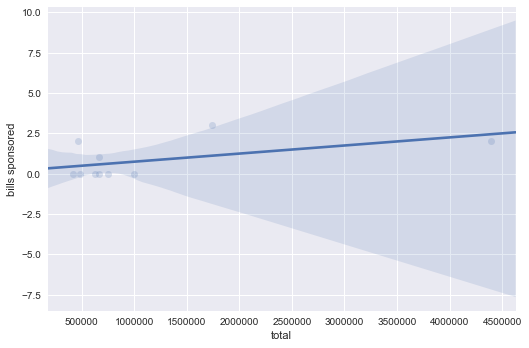

                  industry    total  bills sponsored
0                  Retired  4394008                2
1  Securities & Investment  1743257                3
2              Real Estate   997629                0
3  Republican/Conservative   747260                0
4                Insurance   666849                1
5                Oil & Gas   666683                0
6        Lawyers/Law Firms   627172                0
7     Health Professionals   485294                0
8             Misc Finance   464300                2
9                Lobbyists   413332                0


In [25]:
contributions = get_candidate_contributors('N00004357', 2016, 'y')
print contributions

This gives you some insight for what contribution numbers look like for a single congressperson for a single congressional term. Now let's take a look at what figures look like for a whole committee. (The below function will take a long time to run)

count        10.000000
mean     402308.900000
std      195408.695605
min      226302.000000
25%      283430.250000
50%      323705.000000
75%      455218.000000
max      873937.000000
Name: total, dtype: float64


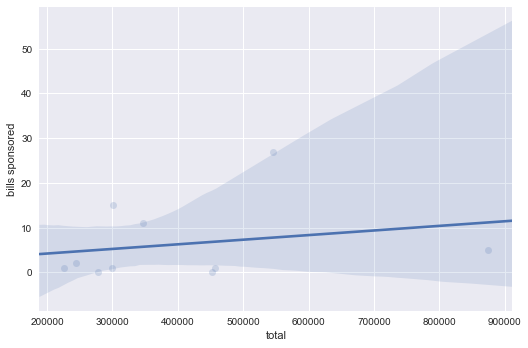

count        10.000000
mean     289430.400000
std       89120.505953
min      181139.000000
25%      257243.750000
50%      275424.000000
75%      295938.500000
max      511294.000000
Name: total, dtype: float64


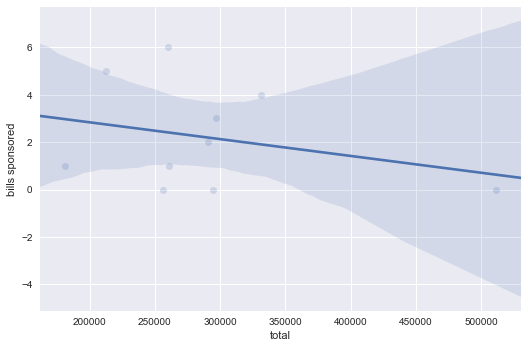

count    1.000000e+01
mean     6.342429e+05
std      3.135394e+05
min      3.266000e+05
25%      3.693120e+05
50%      5.670990e+05
75%      7.908510e+05
max      1.185693e+06
Name: total, dtype: float64


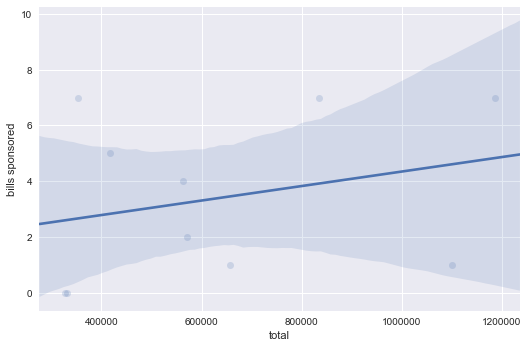

count    1.000000e+01
mean     1.113025e+06
std      5.993241e+05
min      4.556090e+05
25%      6.023988e+05
50%      1.085028e+06
75%      1.342819e+06
max      2.073722e+06
Name: total, dtype: float64


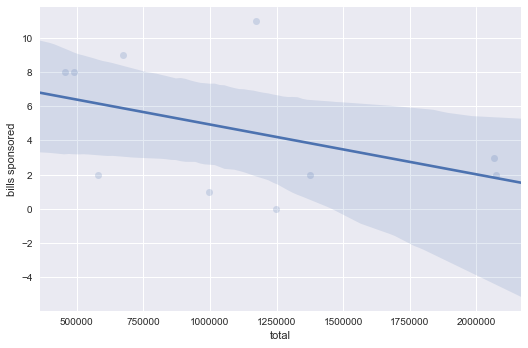

count    1.000000e+01
mean     4.330217e+05
std      3.573564e+05
min      1.790100e+05
25%      2.060682e+05
50%      3.217400e+05
75%      4.211048e+05
max      1.343744e+06
Name: total, dtype: float64


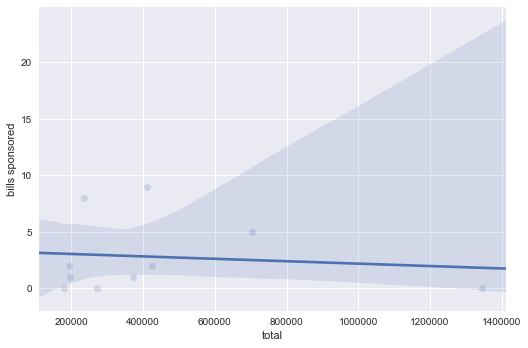

count        10.000000
mean     453049.000000
std      292850.660071
min      205488.000000
25%      221570.500000
50%      299375.000000
75%      627401.250000
max      962289.000000
Name: total, dtype: float64


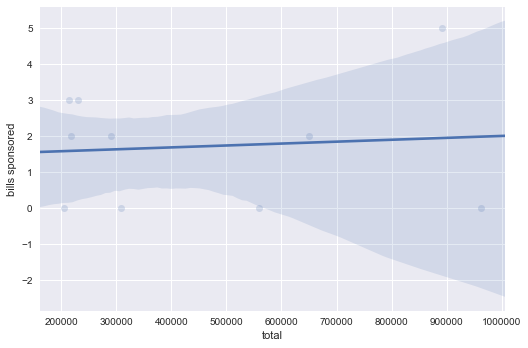

count        10.000000
mean     306769.900000
std      176624.482979
min      150850.000000
25%      188825.500000
50%      267500.000000
75%      356047.000000
max      753808.000000
Name: total, dtype: float64


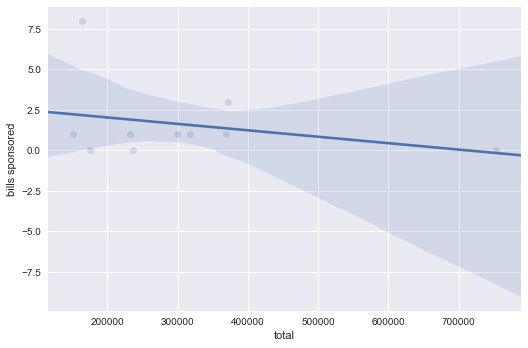

count        10.000000
mean     281869.000000
std      179118.700334
min      154750.000000
25%      179221.250000
50%      189760.000000
75%      343637.750000
max      698702.000000
Name: total, dtype: float64


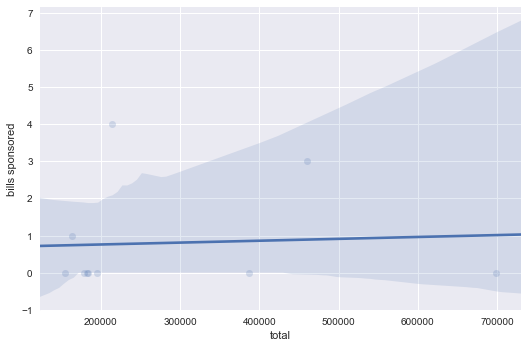

count    1.000000e+01
mean     4.458092e+05
std      3.439729e+05
min      1.684350e+05
25%      2.558932e+05
50%      3.199260e+05
75%      4.168382e+05
max      1.248062e+06
Name: total, dtype: float64


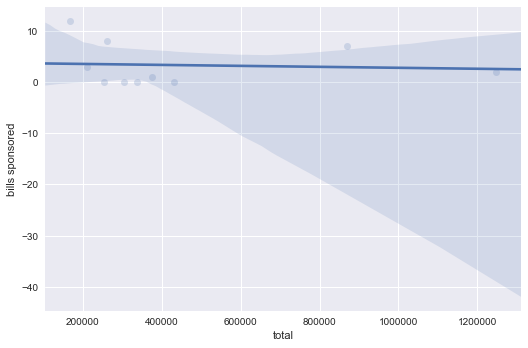

count    1.000000e+01
mean     3.160202e+05
std      2.998815e+05
min      1.388250e+05
25%      1.611298e+05
50%      2.010250e+05
75%      3.094442e+05
max      1.130572e+06
Name: total, dtype: float64


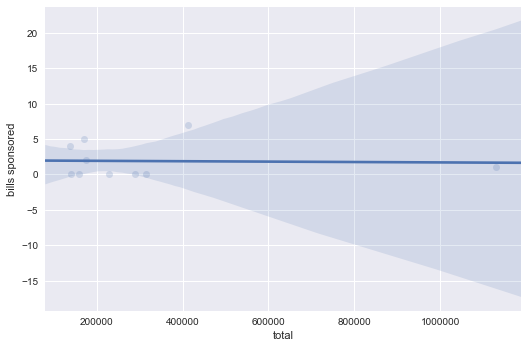

count    1.000000e+01
mean     7.070565e+05
std      5.330052e+05
min      2.421300e+05
25%      3.811170e+05
50%      5.712135e+05
75%      7.938715e+05
max      2.062318e+06
Name: total, dtype: float64


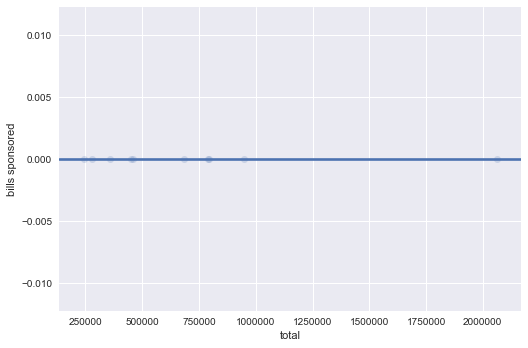

count    1.000000e+01
mean     5.476537e+05
std      4.687366e+05
min      2.199200e+05
25%      2.432170e+05
50%      3.530520e+05
75%      5.659118e+05
max      1.494688e+06
Name: total, dtype: float64


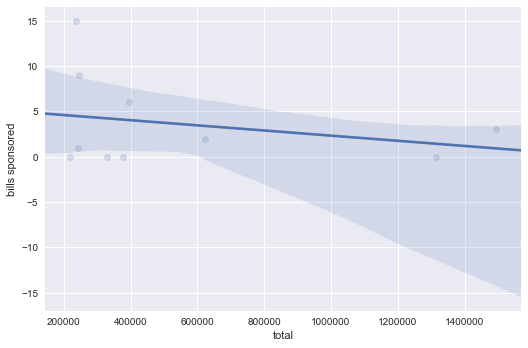

count        10.000000
mean     313526.000000
std      181141.160896
min      160655.000000
25%      216386.000000
50%      238675.000000
75%      320526.750000
max      752826.000000
Name: total, dtype: float64


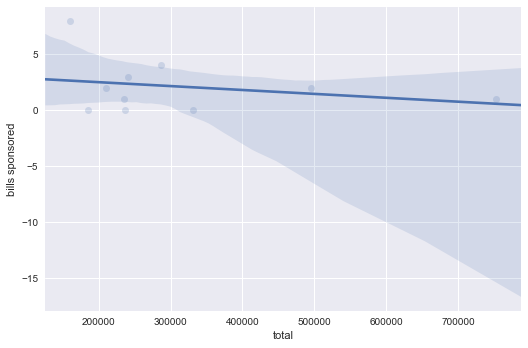

count        10.000000
mean     267045.700000
std      166908.609092
min      148732.000000
25%      172974.250000
50%      225238.000000
75%      287028.250000
max      715407.000000
Name: total, dtype: float64


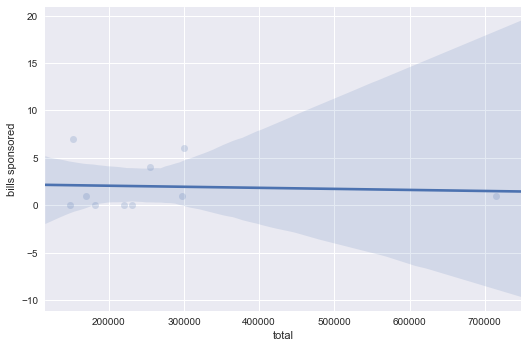

count        10.000000
mean     339847.800000
std      211508.210052
min      191300.000000
25%      205764.500000
50%      236410.000000
75%      408662.500000
max      855400.000000
Name: total, dtype: float64


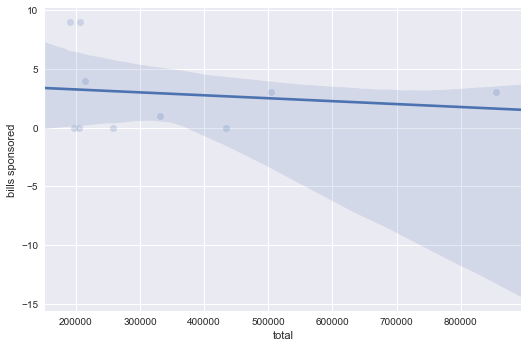

count    1.000000e+01
mean     5.763761e+05
std      2.475333e+05
min      3.898970e+05
25%      4.504230e+05
50%      4.864575e+05
75%      5.463610e+05
max      1.217696e+06
Name: total, dtype: float64


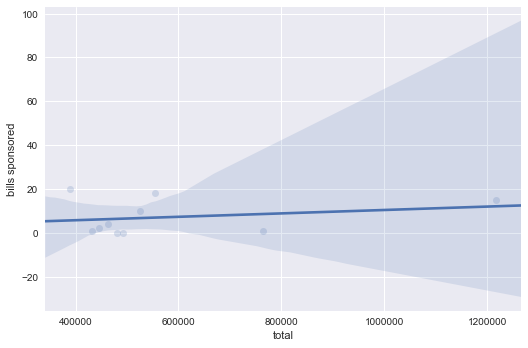

count        10.000000
mean     252173.700000
std      203005.483009
min      117000.000000
25%      147535.250000
50%      183721.500000
75%      236552.500000
max      798401.000000
Name: total, dtype: float64


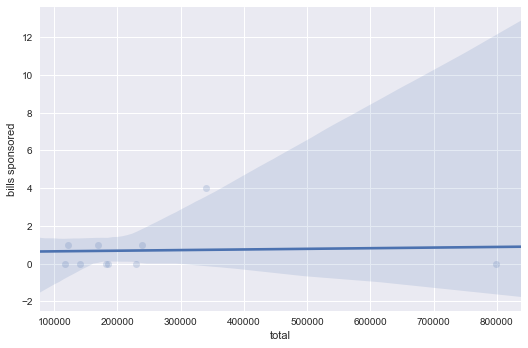

count        10.000000
mean     159975.900000
std      105821.179691
min       52435.000000
25%       86400.000000
50%      109606.500000
75%      227862.000000
max      337899.000000
Name: total, dtype: float64


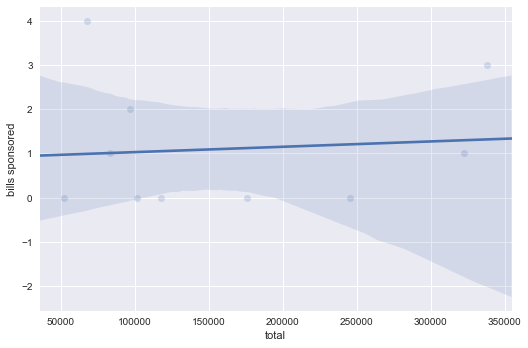

count        10.000000
mean     215839.500000
std      153140.757283
min       81250.000000
25%      119160.500000
50%      161577.000000
75%      258709.250000
max      589972.000000
Name: total, dtype: float64


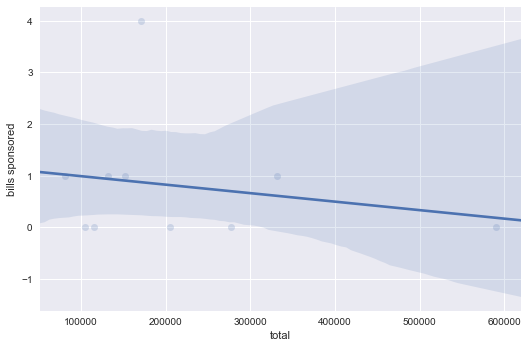

count    1.000000e+01
mean     4.613341e+05
std      3.289113e+05
min      1.972500e+05
25%      2.380830e+05
50%      3.746865e+05
75%      5.613918e+05
max      1.298864e+06
Name: total, dtype: float64


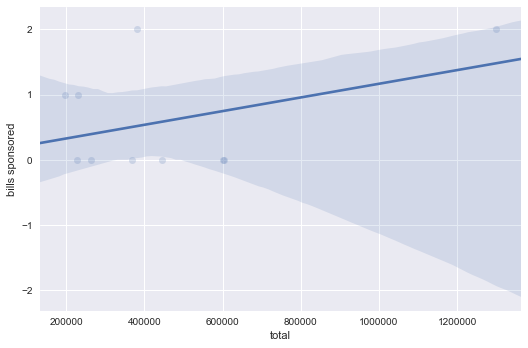

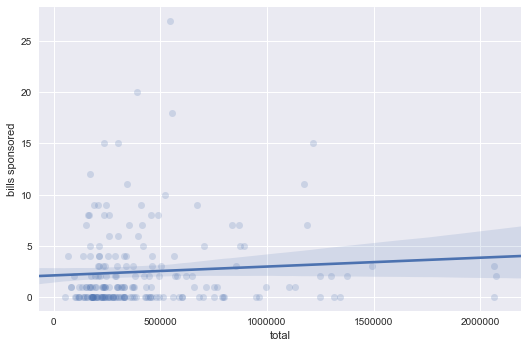

In [26]:
def get_committee_contributors():
    s_env_publicwork = ['N00001758', #In a future version, this method will accept this as a list as opposed 
                        'N00007364', #to have it being written into the method. 
                        'N00024852',
                        'N00033085',
                        'N00009573',
                        'N00009975',
                        'N00031696',
                        'N00035544',
                        'N00031685',
                        'N00031820',
                        'N00036915',
                        'N00029016',
                        'N00027500',
                        'N00027533',
                        'N00006267',
                        'N00009869',
                        'N00028139',
                        'N00034044',
                        'N00009918',
                        'N00035492']
    
    full_list = pd.DataFrame()
    
    for i in range(20): #This gets altered to read parts of the above list. 
        df = get_candidate_contributors(s_env_publicwork[i], 2016, 'y')
        df['person_id'] = s_env_publicwork[i]
        full_list = pd.concat([full_list, df])
    
    sns.lmplot(x='total', y='bills sponsored', data=full_list, aspect=1.5, scatter_kws={'alpha':0.2})
    sns.plt.show()    
        
    return full_list

full_list = get_committee_contributors()

I also built a method that returns visualizations for industry dollars that have been given to specific committees during specific congressional years. This didn't get used in later versions of the analysis, but these could end up being useful methods later on. 

In [27]:
def getCommitteeData(congress_year, committee_code, industry_code):
    #Build API query string
    congress_year = str(congress_year)
    tob_ag = 'https://www.opensecrets.org/api/?method=congCmteIndus&congno=' + congress_year + '&indus=' + industry_code + '&cmte=' + committee_code + '&apikey=806206d71fc3b036b29ea330e74c82e0'
    r = requests.get(tob_ag + '&output=json')
    tob_ag = r.json()
    
    #list of dictionaries
    tob_ag['response']['committee']['member'][1]['@attributes']
    len(tob_ag['response']['committee']['member'][1]['@attributes'])
    
    #The below code takes all the important values from the API output, builds it into a list of lists, and deposits 
    #it into a dataframe
    committee_list = []
    
    for x in range(len(tob_ag['response']['committee']['member'])):
        member_values = [tob_ag['response']['committee']['member'][x]['@attributes']['member_name'], 
                         tob_ag['response']['committee']['member'][x]['@attributes']['party'],
                         tob_ag['response']['committee']['member'][x]['@attributes']['state'],
                         tob_ag['response']['committee']['member'][x]['@attributes']['total'],
                         tob_ag['response']['committee']['member'][x]['@attributes']['indivs'],
                         tob_ag['response']['committee']['member'][x]['@attributes']['pacs']]
        committee_list.append(member_values)
        
    cols = ['member_name', 'party', 'state', 'total', 'indivs', 'pacs']
    committee = pd.DataFrame(committee_list, columns=cols)
    
    #Displays total contributions to committee, individual contributions, pac contributions, and a graph of contributions
    #by congressperson 
    print str(committee.total.astype(int).sum()) + ' : Total dollars donated to this committee'
    print str(committee.indivs.astype(int).sum()) + ' : Individual contributions' 
    print str(committee.pacs.astype(int).sum()) + ' : Pac contributions'
    print str(committee.party.value_counts())
    
    #Graphs committee contributions 
    values = committee[['indivs', 'pacs']].astype(int)
    #names = committee['member_name'].tolist()
    values.plot(kind='bar', stacked=True)
    plt.xlabel('Congressperson')
    plt.ylabel('Dollars donated')
    plt.title('Industry: ' + all_industry_codes.get_value(industry_code, 'Industry') + '      Committee: ' + all_committee_codes.get_value(committee_code, 'code   cmtename')) #Here I need to add the committee name
    #plt.xticks(values, names, rotation='vertical') Have to get this to display the congressperson's name vertically
    plt.show()
    return committee, all_industry_codes.get_value(industry_code, 'Industry')


In [28]:
#This gives you your list of bills that match the search term
def getCongresspersonBills(congress_year, industry):
    bill_query = 'https://www.govtrack.us/api/v2/bill?q=' + industry + '&congress=' + str(congress_year) + '&limit=4'
    print bill_query
    r2 = requests.get(bill_query)
    output = r2.json()
    
    bill_id_list = []
    bill_sponsors_cosponsors = {}
    id_to_scs = {}
    
    #Builds a list of bill IDs for the proper query string
    for x in range(len(output['objects'])): 
        bill_id_list.append(output['objects'][x]['id'])
    #print bill_id_list
    
    #For each bill ID, builds a list of sponsors and cosponsors 
    for x in range(len(bill_id_list)):
        bill_query = 'https://www.govtrack.us/api/v2/bill/' + str(bill_id_list[x])
        r3 = requests.get(bill_query)
        relevant_bills = r3.json()
        
        sponsor = relevant_bills['sponsor']['bioguideid']
        cosponsors = []
        for y in range(len(relevant_bills['cosponsors'])):
            cosponsors.append(relevant_bills['cosponsors'][y]['bioguideid'])

        bill_sponsors_cosponsors['sponsor'] = sponsor
        bill_sponsors_cosponsors['cosponsors'] = cosponsors

        id_to_scs[str(bill_id_list[x])] = bill_sponsors_cosponsors
        print id_to_scs[str(bill_id_list[x])]
          
    return id_to_scs

578030 : Total dollars donated to this committee
167455 : Individual contributions
410575 : Pac contributions
R    25
D    15
Name: party, dtype: int64


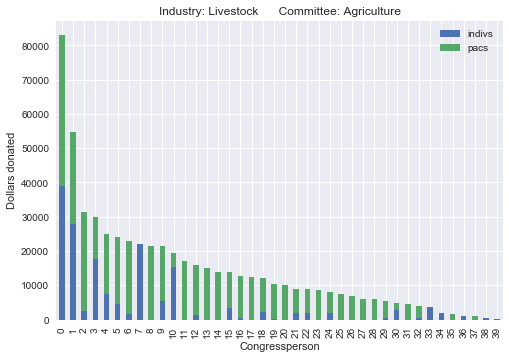

In [29]:
committee_df, industry = getCommitteeData(114, 'HAGR', 'A06')

# 4. Modeling

After seeing that there wasn't much hope for this data being predictive, I just ran a quick linear regression on it just to see how unpredictive it was. It turns out very. 

RMSE = 
4.00775124833


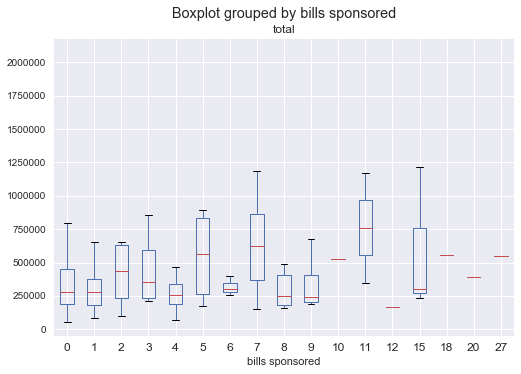

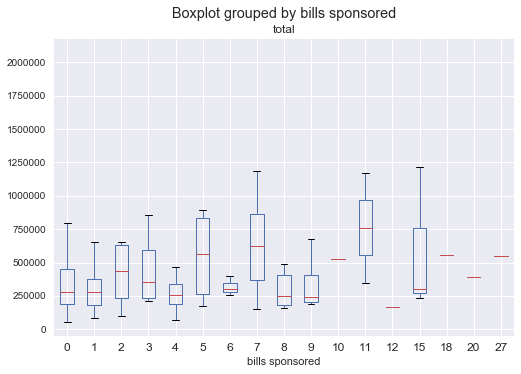

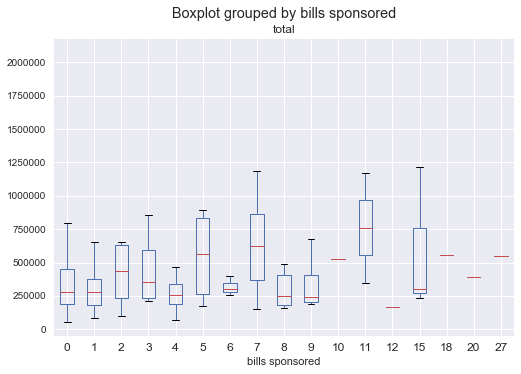

In [36]:
#This function performs linear regression  
def linear_regression():
    linreg = LinearRegression()
    feature_cols = ['total']
    X = full_list[feature_cols]
    y = full_list['bills sponsored']
    #linreg.fit(X, y)
    #print 'intercept = ' + str(linreg.intercept_)
    #print 'coef = ' + str(linreg.coef_)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    print 'RMSE = '
    print np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    full_list.boxplot(column='total', by='bills sponsored')
    sns.plt.show()

linear_regression()

# 5. Conclusions and Further Research

This dataset just isn't predictive in the way I expected it to be. I expected there to be a much more linear relationship between the actions of congresspeople and the dollars they received. That being said, this analysis is useful for starting conversations on outliers. The way that I would use the methods I've created here is to chart the current state of affairs for a particular committee or congressperson and then dive into anything that looked suspicious, like Paul Ryan's $4.5M donation during the 2016 term.   